<img src="./../Banner.png"><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024


Práctica No. 2
==============

*Clasificación de imágenes satelitales con Random Forest*
--------------------------------------------------------------------

Objetivos
---------

-   Familiarizarse con el algoritmo de Random forest.
-   Resolver un problema de clasificación de imágenes satelitales y evaluar métricas de desempeño.


Problema
--------

-   En esta ocasión, trabajaremos con el dataset "EuroSat Dataset". Este conjunto de datos se utiliza para clasificar el uso de la tierra en imágenes geoespaciales.

Este conjunto de datos contiene imágenes que pertenecen al conjunto de datos: [EuroSat Dataset](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset).

**EuroSAT** → Contiene imágenes RGB recopiladas del conjunto de datos Sentinel.

Cada imagen tiene 64x64 píxeles con una distancia de muestreo en el suelo de 10 mt y se encuentran en formato jpg

Para este laboratorio trabajatemos con el fin de facilitar el procesamiento utilizaremos un subconjunto de los datos de la carpeta EuroSAT que se encuentra en el repositorio de Github [EuroSat](https://github.com/hectormelo/Machine-Learning-Techniques/tree/main/Lab_2) y del cual utilizaremos las siguientes carpetas de clases diferentes de imágenes:

1. Forest
2. Industrial
3. PermanentCrop
4. Residential
5. River




### 0. Importación de Librerías

Para este ejercicio, utilizaremos las siguientes librerías.

In [1]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

import cv2
import requests

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión
from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros

from sklearn.preprocessing import StandardScaler # Estandarización de datos

from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión
from sklearn.svm import SVC # Máquina de soporte vectorial
from sklearn.ensemble import RandomForestClassifier #Librería para manejo del algoritmo Random Forest

from PIL import Image #Librería para brir, manipular y guardar muchos formatos diferentes de archivos de imágenes.

from skimage import io
from zipfile import ZipFile
from io import BytesIO


#### 1. Carga y exploración de los datos

Para éste caso vamos a utilizar la imágenes que se encuentran en un archivo zip en el siguiente enlace:

https://github.com/hectormelo/Machine-Learning-Techniques/blob/main/Lab_2/EuroSAT.zip

La idea es descomprimir el archivo en el entorno de trabajo para poder trabajar con ellas.

In [3]:
# Archivo
file = './EuroSAT3.zip'

# Descomprimir el contenido en memoria
with ZipFile(file) as zip_file:
    zip_file.extractall("./EuroSAT")  # Especifica el directorio donde quieres descomprimir
print("Archivo descomprimido.")

Archivo descomprimido.


Debido a que las imágenes con las que contamos en el set de datos son de 64X64, es decir no son tan grandes, no reduciremos el tamaño de las imágenes ya que no impactan el tiempo de procesamiento.

In [4]:
def load_image(folder):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            #image = cv2.resize(image, (width, height))
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

In [5]:
#cargamos las imágenes que se encuentran en EuroSAT
X, y = load_image('./EuroSAT')
#Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Tamaño de los datos
X.shape

(3750, 64, 64, 3)

In [7]:
# Tamaño de los datos de entrenamiento
x_train.shape

(3000, 64, 64, 3)

In [8]:
# Tamaño de los datos de prueba
x_test.shape

(750, 64, 64, 3)

En total encontramos 3.750 imágenes, de 64x64 en formato RGB, es decir maneja 3 canales (rojo, verde y azul)
El conjunto de entrenamiento queda con 3.000 imágenes y el de test con 750


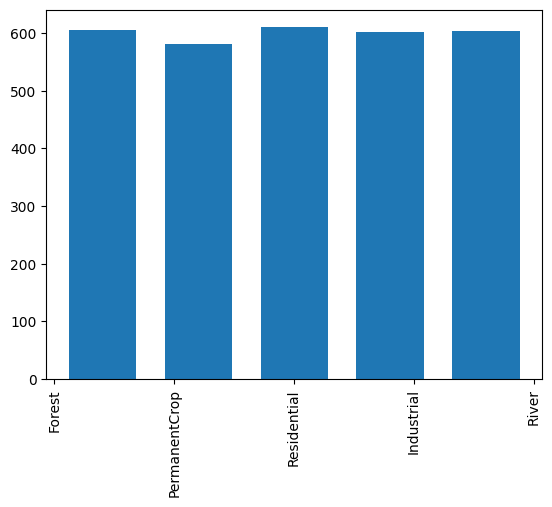

In [9]:
# Observar distribucón de clases
plt.hist(y_train, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()

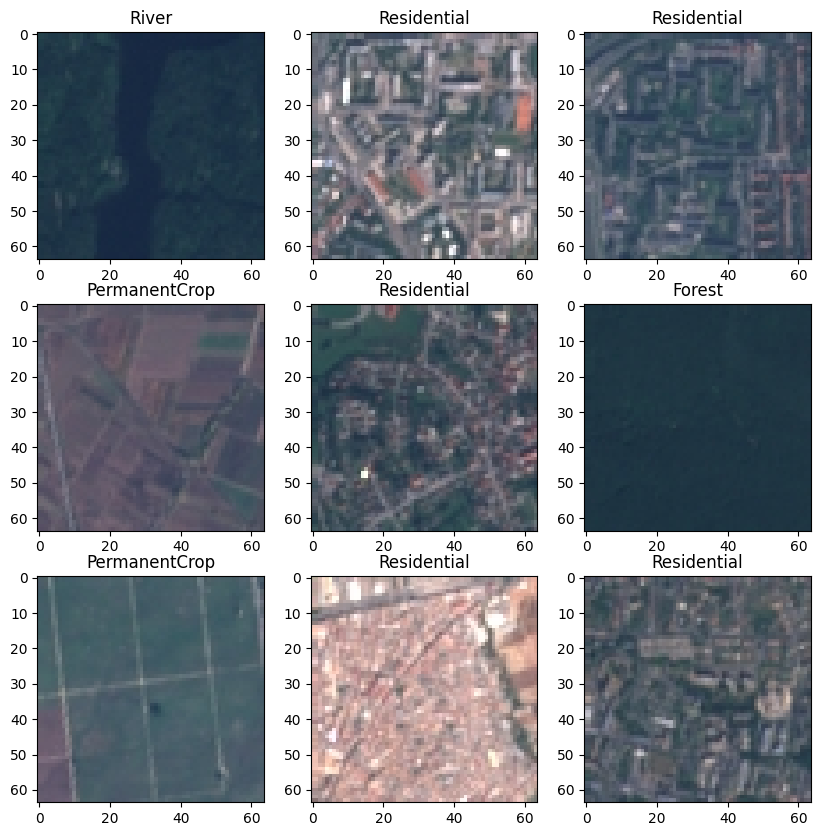

In [10]:
# Observar las imágenes
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])

In [11]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
# Para imprimir cada par clave-valor en una línea nueva de los valores de entrenaimento
print("Distribución de los labels de entrenamiento: ")
dic_entrenamiento=  dict(zip(unique_train, counts_train))
for clave, valor in dic_entrenamiento.items():
    print(f'{clave}: {valor}')
# Para imprimir cada par clave-valor en una línea nueva de los valores de test
print("\nDistribución de los labels de test: ")
dic_test= dict(zip(unique_test, counts_test))
for clave, valor in dic_test.items():
    print(f'{clave}: {valor}')

Distribución de los labels de entrenamiento: 
Forest: 605
Industrial: 601
PermanentCrop: 581
Residential: 610
River: 603

Distribución de los labels de test: 
Forest: 145
Industrial: 149
PermanentCrop: 169
Residential: 140
River: 147


#### 2. Preparación de los Datos

##### 2.1 Estandarizacion

Sabiendo que estamos trabajando con imágenes RGB podríamos hacer estandarización diviendo por 255 (el máximo valor que puede tomar un píxel en una imagen de 8 bits).

Sin embargo, en este caso haremos una aproximación con StandardScaler pues centra los datos en 0 y asegura varianza unitaria.

In [12]:
# Convertir imágenes a vectores 1D
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Estandarizar las imágenes
scaler = StandardScaler().fit(x_train_reshaped)
x_train_standard = scaler.transform(x_train_reshaped)
x_test_standard = scaler.transform(x_test_reshaped)

##### 2.1 PCA (Principal Component Analysis)

PCA puede ayudarnos a reducir el tiempo de entrenamiento y también puede mejorar el rendimiento del modelo al eliminar características redundantes o poco informativas

In [13]:
# Dimensionalidad de los datos sin PCA
x_train_standard.shape

(3000, 12288)

In [14]:
# Conservar el 95% de la varianza
pca = PCA(0.95).fit(x_train_standard)

In [15]:
x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

In [16]:
# Numero de componentes principales
print(f"El número de componente principales que conservan el 95% de la varianza es: {pca.n_components_}")

# Dimensionalidad de los datos con PCA
x_train_pca.shape

El número de componente principales que conservan el 95% de la varianza es: 398


(3000, 398)

Con este procedimiento, reducimos de 12.288 a 399 que conservan el 95% de la varianza, lo que reduce los tiempos de ejecución.

#### 3. Random Forest

El algoritmo de Random Forest es un método de aprendizaje en conjunto (ensemble learning) que opera construyendo múltiples árboles de decisión durante el entrenamiento y produciendo la clase que es la moda de las clasificaciones (para problemas de clasificación) o la media de las predicciones (para problemas de regresión) de los árboles individuales. Random Forest corrige la tendencia de los árboles de decisión a sobreajustarse a su conjunto de entrenamiento, proporcionando un resultado más generalizado y robusto.

##### Crear un clasificador de Random Forest

Lo primero que haremos será crear un clasificador de Random forest.

**RandomForestClassifier:** Esta es la clase de scikit-learn que implementa el algoritmo de Random Forest para problemas de clasificación.

**n_estimators:** Especifica el número de árboles en el bosque. En este caso, se crearán 100 árboles de decisión.

**criterion:** Determina la función para medir la calidad de una división. **'Entropy'** es un criterio para el ganancia de información que se usa para el cálculo de la pureza de los nodos y la selección de las características más importantes. La alternativa sería **'gini'**, que utiliza el índice de Gini para el mismo propósito.

**random_state=0:** Asegura que los resultados sean reproducibles. Fija una semilla para el generador de números aleatorios utilizado por el clasificador.

In [17]:
# Crear un clasificador de Random Forest
clasificador_rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

##### Entrenar el clasificador con los datos de entrenamiento

**fit**: Este método entrena el modelo de Random Forest usando el conjunto de datos de entrenamiento proporcionado. x_train_pca contiene las características de los datos de entrenamiento, ya reducidas en dimensiones mediante PCA(Análisis de Componentes Principales) que utilizamos en el algoritmo de SVA y el conjunto de entrenamiento y_train.

In [18]:
# Entrenar el clasificador con los datos de entrenamiento
# Entrenamiento y creación del modelo
start = time.time()
clasificador_rf.fit(x_train_pca, y_train)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento: {end - start}")

Tiempo de entrenamiento: 9.092890739440918


### Realizar predicciones en los datos de prueba

**predict:** Después de entrenar el modelo, este método se utiliza para realizar predicciones sobre nuevos conjuntos de datos. Aquí, se hace sobre x_test_pca, que son los datos de prueba transformados de la misma manera que los datos de entrenamiento.

In [19]:
# Realizar predicciones en los datos de prueba
y_pred_rf = clasificador_rf.predict(x_test_pca)

Precisión de Random Forest: 0.78

Informe de clasificación de Random Forest:
               precision    recall  f1-score   support

       Forest       0.99      0.98      0.99       145
   Industrial       0.86      0.92      0.89       149
PermanentCrop       0.73      0.70      0.72       169
  Residential       0.69      0.51      0.59       140
        River       0.64      0.78      0.70       147

     accuracy                           0.78       750
    macro avg       0.78      0.78      0.78       750
 weighted avg       0.78      0.78      0.78       750


Matriz de confusión de Random Forest:


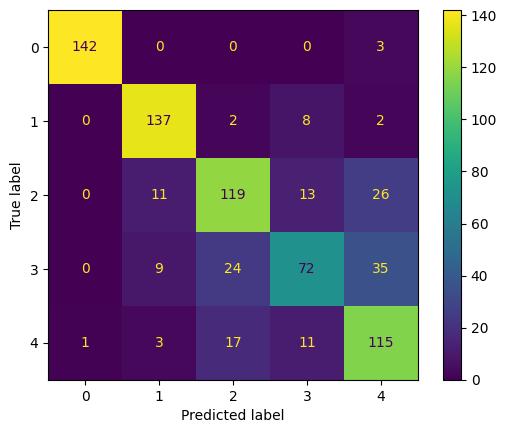

In [20]:
# Desempeño Random Forest

# Precisión
print("Precisión de Random Forest:", accuracy_score(y_test, y_pred_rf))

# Informe de clasificación
print("\nInforme de clasificación de Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()


En este caso podemos ver que el algoritmo de Random Forest tiene un desempeño del 80% en la clasificación.

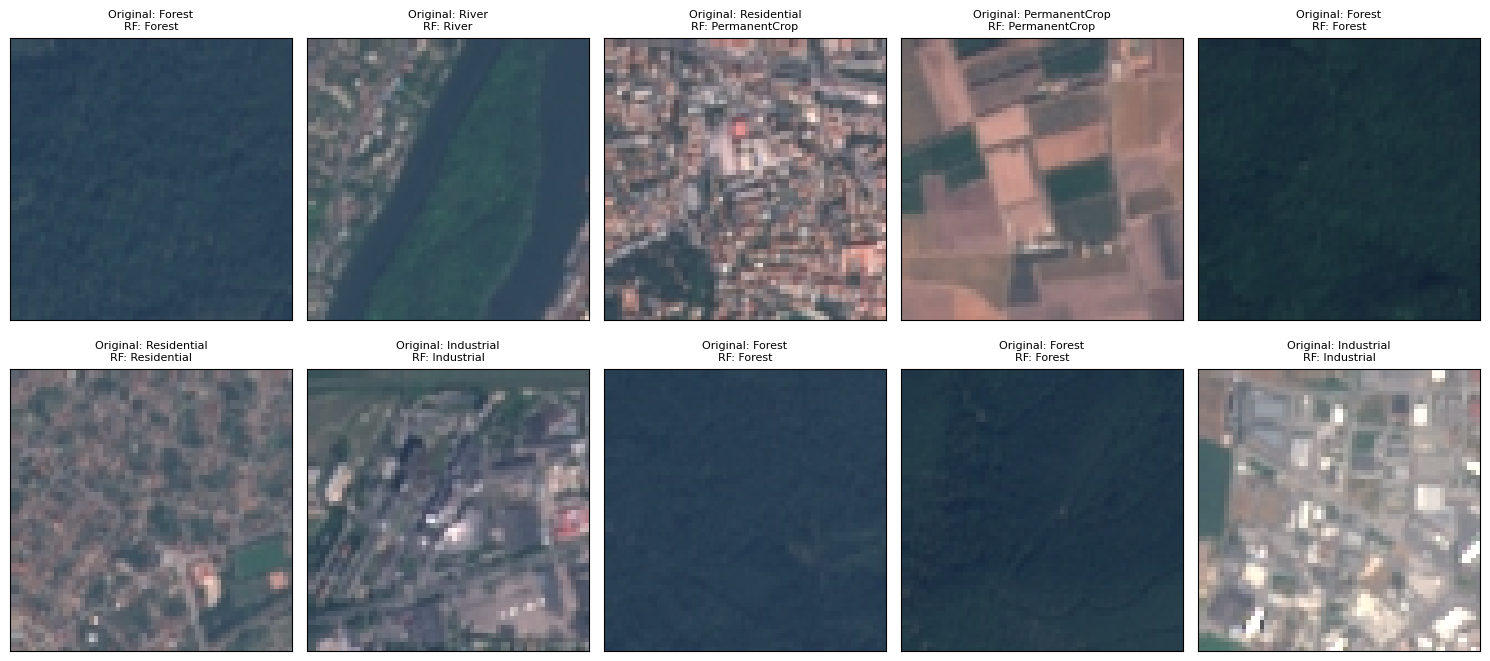

In [21]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest
    predicted_label_rf = clasificador_rf.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original, la predicción de SVM y la predicción de Random Forest
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nRF: {predicted_label_rf[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()

####  Preguntas para el análisis

- ¿PCA con una explicación mayor de la variancia puede ayudar a mejorar el desempeño del modelo?
- ¿Cómo varía el desempeño del modelo si se ajustan los hiperparámetros?

In [23]:
# PCA con varianza de 99%

pca2 = PCA(0.99).fit(x_train_standard)
x_train_pca2 = pca2.transform(x_train_standard)
x_test_pca2 = pca2.transform(x_test_standard)
print(pca2.n_components_)
print(x_train_pca2.shape)

1020
(3000, 1020)


In [26]:
grid_search = GridSearchCV(
    RandomForestClassifier(criterion='entropy'),
    {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split' : [5, 10]
    }
)

grid_search.fit(x_train_pca2, y_train)
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}


In [28]:
# Realizar predicciones en los datos de prueba
y_pred_rf2 = grid_search.predict(x_test_pca2)


Precisión de Random Forest: 0.7933333333333333

Informe de clasificación de Random Forest:
               precision    recall  f1-score   support

       Forest       0.99      0.98      0.99       145
   Industrial       0.80      0.91      0.85       149
PermanentCrop       0.83      0.69      0.75       169
  Residential       0.75      0.59      0.66       140
        River       0.63      0.80      0.71       147

     accuracy                           0.79       750
    macro avg       0.80      0.79      0.79       750
 weighted avg       0.80      0.79      0.79       750


Matriz de confusión de Random Forest:


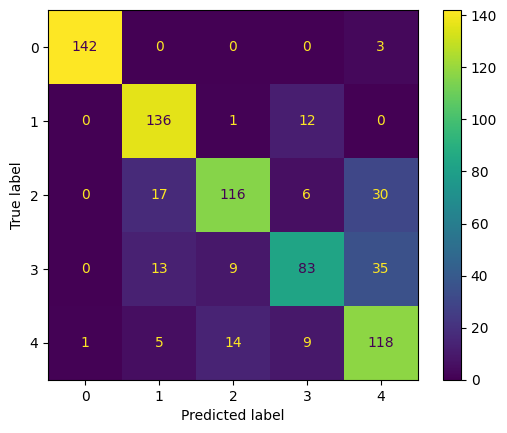

In [29]:
# Desempeño Random Forest con GridCV

# Precisión
print("Precisión de Random Forest:", accuracy_score(y_test, y_pred_rf2))

# Informe de clasificación
print("\nInforme de clasificación de Random Forest:")
print(classification_report(y_test, y_pred_rf2))

# Matriz de confusión
print("\nMatriz de confusión de Random Forest:")
cm_rf2 = confusion_matrix(y_test, y_pred_rf2)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf2)
disp_rf.plot()
